# Job Industry Predictor

Team 9 Members: Alicia Wang, Angela Lin, Juan Alfaro Cortez, Dante Quispe Vilca

Mentor: James Geronimo

## Background

Initial idea: Predict salaries from a specific job                                                                                                                                                                               Final idea: Predict the job industry from the job description

Research Question: "What are the key features and textual patterns that can be used to accurately classify job descriptions into their respective industries using machine learning and NLP techniques?"

Built an ML model that takes in a job description and predicts what job industry the description corresponds to....

## Data collection

We used the Real or Fake Job Posting dataset from Kaggle.

https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

<img src="21ED55C2-0862-4778-90AA-83016BB73B32.jpeg" width="" align="" />

## Relevant Imports

In [ ]:
##### RELEVANT IMPORTS #####
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import PorterStemmer
from PIL import Image

from datascience import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 kB 11.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Data Cleaning

We started by first selecting the columns we would need. In this case, it consisted of the columns: industry, description, country, and employment type. As we were only interested in the top 5 industries, we made a new object called top 5 industries, which we would work with for the rest of the project. 

In [ ]:
real_job_postings = pd.read_csv('real_job_postings.csv')
real_job_postings['location'] = real_job_postings['location'].str.split(', ').str[0]
real_job_postings = real_job_postings[['function', 'description', 'location', 'employment_type']]
real_job_postings = real_job_postings.rename(columns={'location':'country', 'function':'industry'})
real_job_postings = real_job_postings[~real_job_postings['industry'].isnull()]

top_5_industries = real_job_postings['industry'].value_counts().head(5).index
real_job_postings = real_job_postings[real_job_postings['industry'].isin(top_5_industries)].reset_index(drop=True)

real_job_postings['description'][585]

'Devmar International is an outsourcing\xa0company based in Paris with a network\xa0of more than 2,000 candidates and sales\xa0partners. Devmar helps its customers to\xa0develop their business by finding the most\xa0appropriate sales partners (distributors,systems integrators, commercial agents,\xa0etc…)Our customer, a combined unity of CEA\xa0research (Atomic Energy and Alternative\xa0Energies Commission) and CNRS (National\xa0Centre for Scientific Research), specialized in\xa0development of methods for measuring high-tech, for their application in the field of lifesciences, is recruiting their future :\xa0Responsible for market research and\xa0feasibilityMission (for a period of one year) is to\xa0determine the positioning and the best\xa0operating conditions of a new method ofsuper-resolution microscopy developed by\xa0the customer, that could be easier and less\xa0expensive than what is currently available onthe market .The candidate will be responsible for\xa0assessing the potenti

After selecting the most important columns to use, we noticed that our job descriptions would often contain unnecessary characters, words, or lack spaces. This is probably going to affect our machine learning model, so needed to find a solution in the form of RegEx.

In [ ]:
real_job_postings['description'] = real_job_postings['description'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)
real_job_postings['description'] = real_job_postings['description'].str.lower()
real_job_postings['description'] = real_job_postings['description'].str.replace(r'[\xa0]|[^\w\s]', ' ', regex=True)
real_job_postings['description'] = real_job_postings['description'].str.replace(r'http\S+', ' ', regex=True)
real_job_postings['description'] = real_job_postings['description'].str.replace(r'url\S+', ' ', regex=True)
real_job_postings['description'] = real_job_postings['description'].str.replace(r'\s+', ' ', regex=True)

real_job_postings['description'][585]


'devmar international is an outsourcing company based in paris with a network of more than 2 000 candidates and sales partners devmar helps its customers to develop their business by finding the most appropriate sales partners distributors systems integrators commercial agents etc our customer a combined unity of cea research atomic energy and alternative energies commission and cnrs national centre for scientific research specialized in development of methods for measuring high tech for their application in the field of lifesciences is recruiting their future responsible for market research and feasibility mission for a period of one year is to determine the positioning and the best operating conditions of a new method ofsuper resolution microscopy developed by the customer that could be easier and less expensive than what is currently available onthe market the candidate will be responsible for assessing the potential of this new technology abroad therefore good interpersonal skills 

We don't want our machine learning model to pick up on words such as "the", "and", "is", to name a few so we used the stop_words function from the NLTK library to get rid of them. We then created a new column, sig_description, which contained the updated form of the descriptions we wanted to use moving forward.

In [ ]:
#remove unnecessary words from the description 
stop_words = stopwords.words('english')
real_job_postings['sig_description'] = real_job_postings['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
real_job_postings

,industry,description,country,employment_type,sig_description
0,Marketing,food52 a fast growing james beard award winnin...,US,Other,food52 fast growing james beard award winning ...
1,Customer Service,organised focused vibrant awesome do you have ...,NZ,Full-time,organised focused vibrant awesome passion cust...
2,Sales,the company esri environmental systems researc...,US,Full-time,company esri environmental systems research in...
3,Customer Service,the customer service associate will be based i...,US,Part-time,customer service associate based phoenix az ri...
4,Information Technology,position developer job location united states ...,US,Full-time,position developer job location united states ...
...,...,...,...,...,...
6619,Sales,avenue story is looking for a curious ambitiou...,GB,Full-time,avenue story looking curious ambitious adaptab...
6620,Sales,we are seeking an administrator to work in a b...,GB,Full-time,seeking administrator work busy sales environm...
6621,Information Technology,sr java script developer experience 4 10 years...,US,Full-time,sr java script developer experience 4 10 years...
6622,Sales,just in case this is the first time you ve vis...,CA,Full-time,case first time visited website vend award win...


We're done, updated descriptions with all cleaning applied :D. 

In [ ]:
# Checking random descriptions for data cleaning
real_job_postings['sig_description'][585]

'devmar international outsourcing company based paris network 2 000 candidates sales partners devmar helps customers develop business finding appropriate sales partners distributors systems integrators commercial agents etc customer combined unity cea research atomic energy alternative energies commission cnrs national centre scientific research specialized development methods measuring high tech application field lifesciences recruiting future responsible market research feasibility mission period one year determine positioning best operating conditions new method ofsuper resolution microscopy developed customer could easier less expensive currently available onthe market candidate responsible assessing potential new technology abroad therefore good interpersonal skills required candidate position accessible market technology determine best strategy market based needs habits concerned population biologists cell biologists biophysicists seeking super resolution imagery'

## EDA/Visualizations

### Dataframe EDA

We made a few visualizations before building our machine learning model to gain a better understanding of our current dataframe after data cleaning.

We looked at the shape of the dataframe after the data cleaning process and decided that taking 80% of our 6624 rows of data is enough to train our ML model.

In [ ]:
df_shape = real_job_postings.shape
print('Number of rows: ' + str(df_shape[0]))
print('Number of columns: ' + str(df_shape[1]))

Number of rows: 6624
Number of columns: 5


For the top5 job industries, count the occurrences of each unique industry in the 'industry' column.

In [ ]:
real_job_postings['industry'].value_counts()#.head()

Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Name: industry, dtype: int64

Use a bar graph to visualize the number of occurrences for the top5 job industries. To create a better visualization, rotate the industry name by 75 degrees.

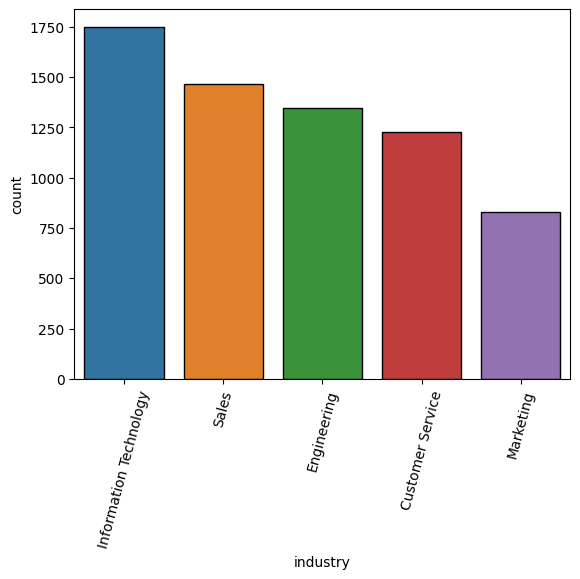

In [ ]:
# https://stackoverflow.com/questions/46623583/order-categories-by-count-in-a-seaborn-countplot

%matplotlib inline
top_5_industry_df = real_job_postings[real_job_postings['industry'].isin(top_5_industries)]
sns.countplot(data=top_5_industry_df, x='industry', order=top_5_industry_df['industry'].value_counts().index)
plt.xticks(rotation=75)
plt.show()

### Word Cloud

Word cloud is a graph filled with lots of words in different sizes, which represent the frequency or the importance of each word. This visualization can help quickly identify the most important themes or topics in a large body of text and communicate the key ideas or concepts in a visually engaging way. We used the wordcloud library for this visualization.

Before creating a wordcloud, we have to group all of the descriptions that belongs to each unique industry together into a single string. So we created a function that takes in an argument called 'industry', representing the name of the specific industry for which the function should be applied, and returns the combined description string.

In [ ]:
def joinDescription(industry):
    only_industry = real_job_postings[real_job_postings['industry'] == industry]
    combined_description = ' '.join(only_industry['sig_description'])
    return combined_description

We created another function that takes in a description as the argument and displays the WordCloud of each unique industry. We will apply this function to every unique industry later.

In [ ]:
def print_graph(one_description):
    #start with one description
    text = one_description
    #create and generate a word cloud image with white background
    wordcloud = WordCloud(background_color="white").generate(text)
    #find the name of the industry that corresponds to the description
    test = new_df[new_df['full_description'] == one_description]['unique_industry']
    print(test)
    #display the generated image
    %matplotlib inline
    #bilinear makes the displayed image appear more smoothly.
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In this coding block, we found all the unique industries and applied the joinDescription() function, which puts all the descriptions of the same industry together. We created a new dataframe called new_df to store each unique industry and its full description.

In [ ]:
all_industry = real_job_postings['industry'].unique()
all_joined_descriptions = []
for industry in all_industry:
    all_joined_descriptions.append(joinDescription(industry))
data = {
    'unique_industry': all_industry,
    'full_description': all_joined_descriptions
}
new_df = pd.DataFrame(data)
new_df

,unique_industry,full_description
0,Marketing,food52 fast growing james beard award winning ...
1,Customer Service,organised focused vibrant awesome passion cust...
2,Sales,company esri environmental systems research in...
3,Information Technology,position developer job location united states ...
4,Engineering,looking hands qa leader talented r amp team lo...


Using .apply on the print_graph function defined above, we showed the wordcloud graph of the most common word used in each unique industry description.

0    Marketing
Name: unique_industry, dtype: object


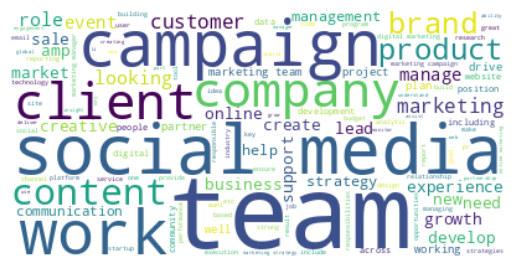

1    Customer Service
Name: unique_industry, dtype: object


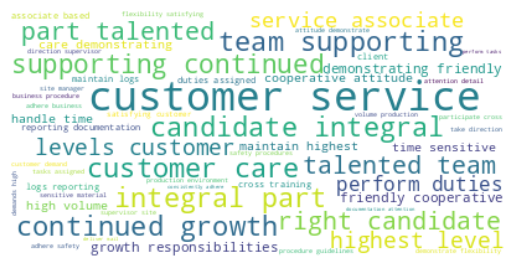

2    Sales
Name: unique_industry, dtype: object


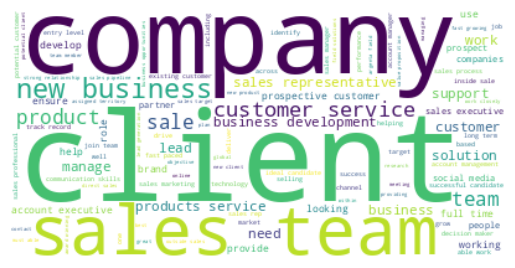

3    Information Technology
Name: unique_industry, dtype: object


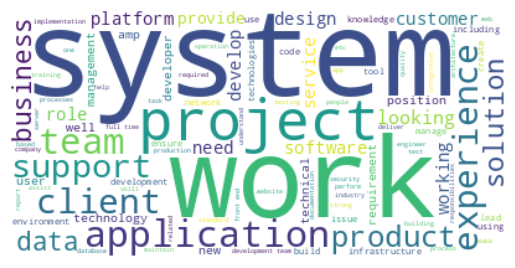

4    Engineering
Name: unique_industry, dtype: object


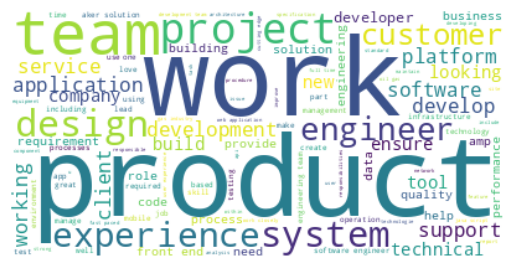

0    None
1    None
2    None
3    None
4    None
Name: full_description, dtype: object

In [ ]:
new_df['full_description'].apply(print_graph)

## Machine Learning/Natural Language Processing

### Top 5 Words Model

We used a text processing and analysis: https://www.linkedin.com/pulse/tfidf-what-how-can-i-build-my-own-machine-learning-david-adamson-mbcs/

The "Top 5 Words" model stands as a pivotal tool for understanding the essence of large text corpora. By highlighting the most prominent terms, we gain immediate insights and can drive focused discussions on the textual data under consideration.

Tokenization and Integer Encoding: we commence by creating a dictionary to map each unique word to a unique integer (word2idx) and a list to hold these integer-encoded documents (tokenized_docs)

In [ ]:
idx = 0 
word2idx = {} 
tokenized_docs = [] 
for doc in real_job_postings['sig_description']: 
  words = word_tokenize(doc.lower())
  doc_as_int = []
  for word in words:
    if word not in word2idx:
      word2idx[word] = idx
      idx += 1
        # save for later
    doc_as_int.append(word2idx[word])
  tokenized_docs.append(doc_as_int)

In [ ]:
# reverse mapping
# if you do it smarter you can store it as a list
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:
# number of documents
N = len(real_job_postings['sig_description'])

In [ ]:
# number of words
V = len(word2idx)

In [ ]:
# instantiate term-frequency matrix
# note: you could use also use count vectorizer here too
tf = np.zeros((N, V))

In [ ]:
# populate term frequency counts
for i, doc_as_int in enumerate(tokenized_docs):
  for j in doc_as_int:
    tf[i, j] += 1

In [ ]:
# compute IDF Note that can be derived from the TF matrix
document_freq = np.sum(tf > 0, axis=0) # document frequency (shape = (V,))
idf = np.log(N / document_freq)

In [ ]:
#  compute TF-IDF
tf_idf = tf * idf

Stabilizing the Process: We set a random seed for reproducibility, ensuring consistent each time the process is run.

In [ ]:
np.random.seed(225) # Original seed was 123, 225, 553
# pick a random document, show the top 5 terms (in terms of tf_idf score)
i = np.random.choice(N)
row = real_job_postings.iloc[i]
print("Label:", row['industry'])
print("Text:", row['sig_description'].split("\n", 1)[0])
print("Top 5 terms:")

scores = tf_idf[i]
indices = (-scores).argsort()

for j in indices[:5]:
  print(idx2word[j])

Label: Marketing
Text: looking great part time internship position last approximately 3 months could extend longer running errands us like companies hire interns getting great hands experience earn 10 per hour learn seo search engine optimization social media marketing sem search engine marketing
Top 5 terms:
engine
errands
search
longer
interns


### Multinomial Naive Bayes Model

Multinomial NB: https://www.geeksforgeeks.org/applying-multinomial-naive-bayes-to-nlp-problems/#

Multinomial Naive Bayes is a variant of the Naive Bayes algorithm, particularly well-suited for text classification tasks. It operates under the “naive” assumption of independence between features in a dataset. In the context of text, it treats each word as an independent feature based on Bayes’ theorem.

We chose MNB because it is straightforward to implement and interpret, and is user-friendly. Also, it is fast and works well with large datasets. In MNB, documents like job descriptions are converted into feature vectors. Each dimension of the vector represents the frequency of a particular word in the document. The model also calculates the probability of a document belonging to a particular class like a job industry based on the presence of words in it. Finally, the job description is classified into the industry category for which the computed probability is highest.

Preprocessing: we did tokenization (turning our descriptions into just words) and stop-word removal (removing filler words like a, the...), but we didn't do stemming or lemmatization because of the time constraints. The lack of stemming or lemmatization might affect our models’ ability to generalize across different forms of a word. For instance, “management”, “manager”, and “managing” might be treated as separate features, which could potentially reduce our model’s accuracy.

Disadvantage: while MNB is simple and fast, its assumption of feature independence can limit its accuracy, particularly if there are strong dependencies between words in our job descriptions.

Sklearn Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'real_job_postings' contains your dataset with 'sig_description' and 'industry' columns

# Split the data into training and testing sets
X = real_job_postings['sig_description']
Y = real_job_postings['industry']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 74.04%


In [ ]:
# Sample job description text for prediction
job_description = "job description software developer expertise python machine learning"

# Vectorize the job description using the same TF-IDF vectorizer
job_description_tfidf = vectorizer.transform([job_description])

# Predict the industry for the job description
predicted_industry = model.predict(job_description_tfidf)

# Get the predicted industry label
predicted_label = predicted_industry[0]

# Print the predicted industry label
print(f"Predicted Industry: {predicted_label}")

Predicted Industry: Information Technology


In [ ]:
# Sample job description text for prediction
job_description = "customer talk communicate help assist walmart service highest team level"

# Vectorize the job description using the same TF-IDF vectorizer
job_description_tfidf = vectorizer.transform([job_description])

# Predict the industry for the job description
predicted_industry = model.predict(job_description_tfidf)

# Get the predicted industry label
predicted_label = predicted_industry[0]

# Print the predicted industry label
print(f"Predicted Industry: {predicted_label}")

Predicted Industry: Customer Service


## Conclusion

- Cleaning data was the most important part of the project, since we could not have done the visualizations and the ml model without it

- According to our data, the top five industries are IT, Sales, Engineering, customer service and marketing

- Multinomial Naive Bayes is a suitable choice for our project because it involves text classification, like categorizing job industries based on descriptions.

- We were able to create a machine learning model to predict job industry from job description words